# check oof df

In [1]:
import os
import gc
import yaml
import argparse

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("/kaggle/src/dss_utils")
sys.path.append("/kaggle/src/exp")
sys.path.append("/kaggle/src/model")
sys.path.append("/kaggle/src/data")
from dss_metrics import score
from training_loop import get_valid_values_dict, concat_valid_input_info, get_oof_df, get_key_df
from dss_model import get_model
from dss_dataloader import get_loader


In [2]:
output_dir = "/kaggle/working"
exp_name = "exp017_inputtargettd_flip_epoch10"

folds = [0, 1, 2, 3, 4]
oof_df = pd.DataFrame()
for i in folds:
    print("fold", i)
    # df = pd.read_parquet(os.path.join(output_dir, "_oof", exp_name, f"raw_oof_df_fold{i}.parquet"))
    df = pd.read_parquet(os.path.join(output_dir, "_oof", exp_name, f"oof_df_fold{i}.parquet"))
    oof_df = pd.concat([oof_df, df], axis=0)


fold 0
fold 1
fold 2
fold 3
fold 4


In [3]:
oof_df = oof_df.sort_values(["series_id", "step"])
display(oof_df)


,series_id,step,anglez,enmo,second,minute,date,anglez_mean_36,enmo_mean_36,anglez_std_36,...,enmo_std_60,event,event_onset,event_wakeup,series_date_key,series_date_key_str,fold,class_pred,class_target,event_pred
0,038441c925bb,3240.0,67.174698,0.0155,0,0,2018-08-15,70.279156,0.023275,3.235372,...,0.012594,0.0,0,0,1,038441c925bb_2018-08-15,1,0.155068,0.0,0.071198
1,038441c925bb,3252.0,71.705597,0.0225,0,1,2018-08-15,69.590602,0.014158,2.999046,...,0.013333,0.0,0,0,1,038441c925bb_2018-08-15,1,0.059394,0.0,0.000000
2,038441c925bb,3264.0,69.918900,0.0004,0,2,2018-08-15,70.143925,0.006692,2.645906,...,0.011092,0.0,0,0,1,038441c925bb_2018-08-15,1,0.037147,0.0,0.000000
3,038441c925bb,3276.0,71.789497,0.0015,0,3,2018-08-15,71.615050,0.002158,1.635097,...,0.007597,0.0,0,0,1,038441c925bb_2018-08-15,1,0.033828,0.0,0.000000
4,038441c925bb,3288.0,73.166000,0.0035,0,4,2018-08-15,72.143328,0.005114,1.191563,...,0.004948,0.0,0,0,1,038441c925bb_2018-08-15,1,0.031844,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1379635,fe90110788d2,589260.0,20.082800,0.0454,0,55,2017-09-07,31.033169,0.029017,19.856237,...,0.029438,-1.0,0,0,7744,fe90110788d2_2017-09-07,2,0.005174,-1.0,-0.000000
1379636,fe90110788d2,589272.0,52.714199,0.1222,0,56,2017-09-07,38.098789,0.030378,24.120270,...,0.026770,-1.0,0,0,7744,fe90110788d2_2017-09-07,2,0.005950,-1.0,-0.000000
1379637,fe90110788d2,589284.0,67.082703,0.0262,0,57,2017-09-07,42.944661,0.031164,23.242579,...,0.027069,-1.0,0,0,7744,fe90110788d2_2017-09-07,2,0.008223,-1.0,-0.000000
1379638,fe90110788d2,589296.0,38.784698,0.0018,0,58,2017-09-07,51.018502,0.025467,14.423478,...,0.030690,-1.0,0,0,7744,fe90110788d2_2017-09-07,2,0.020005,-1.0,-0.000000


In [4]:
# postprocess_fn
# series_idでgroupbyして、class_predに対して対象の列のデータから前のN個の列までのデータの平均をとる
import torch
import torch.nn as nn


# 1step 0.5secで30minなら60*30=1800step
def postprocess_downsample_fn(df, N=3, maxpool_kernel_size=3, maxpool_stride=1):
    df = df.copy()
    df = df[df["second"]==0].reset_index(drop=True)
    df["class_pred_beforemean"] = df.groupby("series_id")["class_pred"].apply(lambda x: x.rolling(N, min_periods=1).mean())
    df["class_pred_aftermean"] = df.groupby("series_id")["class_pred"].apply(lambda x: x[::-1].rolling(N, min_periods=1).mean()[::-1])
    df["event_pred"] = df["class_pred_beforemean"] - df["class_pred_aftermean"]
    not_predicted_mask = (df["class_pred"] != -1).astype(int)
    df["event_pred"] = df["event_pred"] * not_predicted_mask

    # 入力サイズと出力サイズが一致するようにpaddingを調整
    maxpool_padding = int((maxpool_kernel_size - maxpool_stride) / 2)
    # maxpoolしてピーク検出
    max_pooling = nn.MaxPool1d(maxpool_kernel_size, stride=maxpool_stride, padding=maxpool_padding)
    event_pred = df["event_pred"].values
    event_pred = torch.tensor(event_pred).unsqueeze(0)
    pooled_event_pred = max_pooling(np.abs(event_pred)).squeeze(0).numpy()
    event_pred = event_pred.squeeze(0).numpy()
    # peakのところだけ残すmaskを作成
    peak_event_pred_mask = np.where(pooled_event_pred == np.abs(event_pred), 1, 0)
    peak_event_pred = event_pred * peak_event_pred_mask
    df["event_pred"] = peak_event_pred
    df = df.drop(["class_pred_beforemean", "class_pred_aftermean"], axis=1)
    return df

def postprocess_downsample_notmaxpool(df, N=11):
    df = df.copy()
    df["class_pred_beforemean"] = df.groupby("series_id")["class_pred"].apply(lambda x: x.rolling(N, min_periods=1).mean())
    df["class_pred_aftermean"] = df.groupby("series_id")["class_pred"].apply(lambda x: x[::-1].rolling(N, min_periods=1).mean()[::-1])
    df["event_pred"] = df["class_pred_beforemean"] - df["class_pred_aftermean"]
    df = df.drop(["class_pred_beforemean", "class_pred_aftermean"], axis=1)
    return df

def make_submission_df(df, threshold=0.1):
    df = df[["series_id", "step", "event_pred"]].copy()
    # thresholdより大きいときは1,-thresholdより小さいときは-1,それ以外は0
    df["event"] = df["event_pred"].apply(lambda x: 1 if x > threshold else -1 if x < -threshold else 0)
    df = df[df["event"] != 0].copy()
    df["event"] = df["event"].replace({1: "wakeup", -1: "onset"})
    df["score"] = df["event_pred"].apply(lambda x: np.clip(np.abs(x), 0.0, 1.0))
    return df


In [5]:
train_event_df = pd.read_csv("/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv")
train_event_df = train_event_df[train_event_df["step"].notnull()].copy()
train_event_df = train_event_df.reset_index(drop=True)
display(train_event_df.head())


,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


In [6]:
oof_df = postprocess_downsample_fn(oof_df, N=11, maxpool_kernel_size=3, maxpool_stride=1)
sub_df = make_submission_df(oof_df, threshold=0.01)


In [7]:
series_id_list =[]
score_list = []
detected_event_num_list = []
for series_id in train_event_df["series_id"].unique():
    scoring_event_df = train_event_df[train_event_df["series_id"] == series_id].copy()
    scoring_sub_df = sub_df[sub_df["series_id"] == series_id].copy()
    if len(scoring_sub_df) == 0 or len(scoring_event_df) == 0:
        series_id_list.append(series_id)
        series_score = 0
        score_list.append(series_score)
        detected_event_num_list.append(len(scoring_sub_df))
        print(series_id, series_score, len(scoring_sub_df), len(scoring_event_df))
    else:
        series_score = score(scoring_event_df, scoring_sub_df)
        series_id_list.append(series_id)
        score_list.append(series_score)
        detected_event_num_list.append(len(scoring_sub_df))
        print(series_id, series_score)


038441c925bb 0.7363336471186677
03d92c9f6f8a 0.7290361201298701
0402a003dae9 0.6649306173027074
04f547b8017d 0.8151244615798754
05e1944c3818 0.8602968460111318
062cae666e2a 0.7768939393939394
062dbd4c95e6 0.5947722625588223
08db4255286f 0.8504402853409292
0a96f4993bd7 0.6305610890471185
0cd1e3d0ed95 0.9070238095238095
0ce74d6d2106 0.8726080179733732
0cfc06c129cc 0.7945023590724442
0d0ad1e77851 0.8523185784223517
0dee4fda51c3 0.7417270648292109
0ec9fc461819 0.868132265364087
0ef7d94fde99 0.8029329632742286
0f572d690310 0.7618977290479596
10469f6765bf 0.4899350649350649
1087d7b0ff2e 0.6524362895868976
10f8bc1f7b07 0.8488474398856851
12d01911d509 0.7176402392440574
1319a1935f48 0.8026313414118424
137771d19ca2 0.85625
137b99e936ab 0.676141282683506
13b4d6a01d27 0.7375
148471991ffb 0.4577779084880059
154fe824ed87 0.795203800971098
16fe2798ed0f 0.678986841486614
1716cd4163b2 0.7458916174894398
1762ab70ec76 0.5891701033285184
188d4b7cd28b 0.7937488859517361
18a0ca03431d 0.8058560296562332
18b

In [8]:
score_df = pd.DataFrame({
    "series_id": series_id_list,
    "score": score_list,
    "detected_event_num": detected_event_num_list
})
score_df.to_csv(os.path.join(output_dir, exp_name, "score_df.csv"), index=False)


,series_id,score,detected_event_num
0,aed3850f65f0,0.950000,7
1,3be2f86c3e45,0.927083,46
2,405df1b41f9f,0.919444,48


<Axes: >

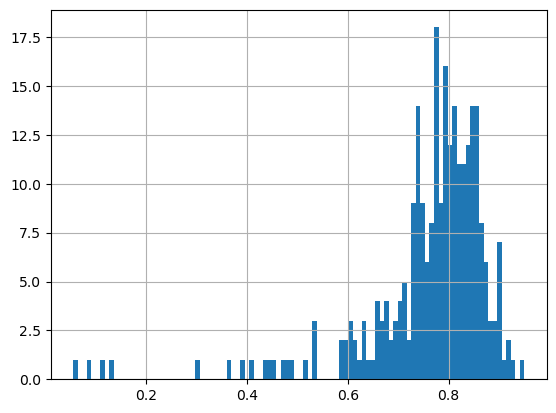

In [9]:
score_df = score_df.sort_values("score", ascending=False).reset_index(drop=True)
display(score_df.head(3))
score_df["score"].hist(bins=100)


In [10]:
score_df = score_df.sort_values("score", ascending=True).reset_index(drop=True)
display(score_df.head(10))
bad_detect_series_id_list = score_df[score_df["score"] < 0.5]["series_id"].values.tolist()

print(bad_detect_series_id_list)
pd.DataFrame({"series_id": bad_detect_series_id_list}).to_csv(os.path.join(output_dir, exp_name, "bad_detect_series_id_list.csv"), index=False)


,series_id,score,detected_event_num
0,60d31b0bec3b,0.055131,388
1,f56824b503a0,0.082019,138
2,4feda0596965,0.115795,188
3,e4500e7e19e1,0.127249,24
4,854206f602d0,0.305684,53
5,b7fc34995d0f,0.367857,23
6,c535634d7dcd,0.394813,137
7,7476c0bd18d2,0.405163,45
8,db5e0ee1c0ab,0.435557,551
9,60e51cad2ffb,0.448291,50


['60d31b0bec3b', 'f56824b503a0', '4feda0596965', 'e4500e7e19e1', '854206f602d0', 'b7fc34995d0f', 'c535634d7dcd', '7476c0bd18d2', 'db5e0ee1c0ab', '60e51cad2ffb', '148471991ffb', 'df33ae359fb5', '73fb772e50fb', '10469f6765bf']


In [11]:
oof_df


,series_id,step,anglez,enmo,second,minute,date,anglez_mean_36,enmo_mean_36,anglez_std_36,...,enmo_std_60,event,event_onset,event_wakeup,series_date_key,series_date_key_str,fold,class_pred,class_target,event_pred
0,038441c925bb,3240.0,67.174698,0.0155,0,0,2018-08-15,70.279156,0.023275,3.235372,...,0.012594,0.0,0,0,1,038441c925bb_2018-08-15,1,0.155068,0.0,0.109445
1,038441c925bb,3252.0,71.705597,0.0225,0,1,2018-08-15,69.590602,0.014158,2.999046,...,0.013333,0.0,0,0,1,038441c925bb_2018-08-15,1,0.059394,0.0,0.000000
2,038441c925bb,3264.0,69.918900,0.0004,0,2,2018-08-15,70.143925,0.006692,2.645906,...,0.011092,0.0,0,0,1,038441c925bb_2018-08-15,1,0.037147,0.0,0.000000
3,038441c925bb,3276.0,71.789497,0.0015,0,3,2018-08-15,71.615050,0.002158,1.635097,...,0.007597,0.0,0,0,1,038441c925bb_2018-08-15,1,0.033828,0.0,0.000000
4,038441c925bb,3288.0,73.166000,0.0035,0,4,2018-08-15,72.143328,0.005114,1.191563,...,0.004948,0.0,0,0,1,038441c925bb_2018-08-15,1,0.031844,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6896815,fe90110788d2,589260.0,20.082800,0.0454,0,55,2017-09-07,31.033169,0.029017,19.856237,...,0.029438,-1.0,0,0,7744,fe90110788d2_2017-09-07,2,0.005174,-1.0,-0.000000
6896816,fe90110788d2,589272.0,52.714199,0.1222,0,56,2017-09-07,38.098789,0.030378,24.120270,...,0.026770,-1.0,0,0,7744,fe90110788d2_2017-09-07,2,0.005950,-1.0,-0.000000
6896817,fe90110788d2,589284.0,67.082703,0.0262,0,57,2017-09-07,42.944661,0.031164,23.242579,...,0.027069,-1.0,0,0,7744,fe90110788d2_2017-09-07,2,0.008223,-1.0,-0.000000
6896818,fe90110788d2,589296.0,38.784698,0.0018,0,58,2017-09-07,51.018502,0.025467,14.423478,...,0.030690,-1.0,0,0,7744,fe90110788d2_2017-09-07,2,0.020005,-1.0,-0.000000


In [12]:
orig_df = pd.read_parquet("/kaggle/input/targetdownsample_train_series_fold.parquet")


In [13]:
orig_df["series_date_key"]


0              1
1              1
2              1
3              1
4              1
            ... 
82761835    7744
82761836    7744
82761837    7744
82761838    7744
82761839    7744
Name: series_date_key, Length: 82761840, dtype: int64

60d31b0bec3b
12


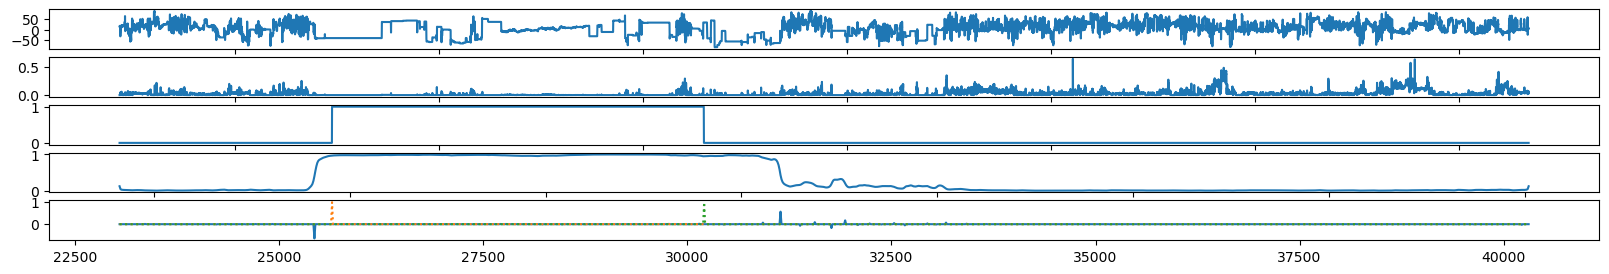

f56824b503a0
12


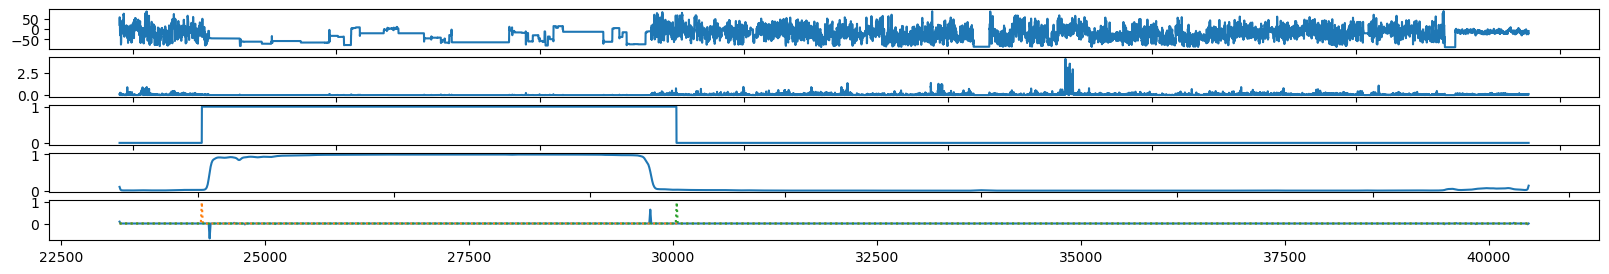

4feda0596965
15


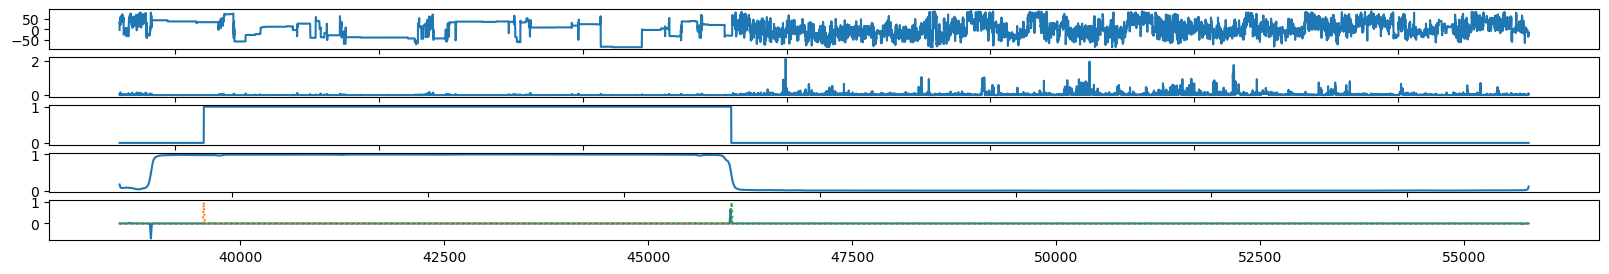

e4500e7e19e1
3


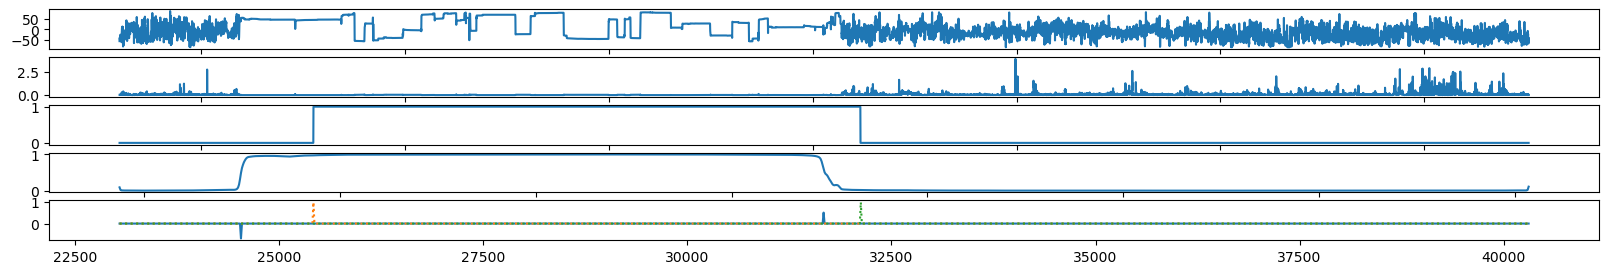

In [14]:
display_col = ["series_id", "series_date_key", "date","fold", "step"]
for idx, series_id in enumerate(bad_detect_series_id_list):
    if idx > 3:
        break
    print(series_id)
    input_df = orig_df[orig_df["series_id"] == series_id]
    pred_df = oof_df[oof_df["series_id"] == series_id]
    key_unique = input_df["series_date_key"].unique()
    print(len(key_unique))
    for key in key_unique:
        input_key_df = input_df[input_df["series_date_key"] == key]
        start_step = input_key_df["step"].min()
        end_step = input_key_df["step"].max()
        pred_key_df = pred_df[(pred_df["step"] >= start_step) & (pred_df["step"] <= end_step)]
        plt.figure(figsize=(20, 3))
        plt.subplot(5, 1, 1)
        plt.plot(input_key_df["anglez"])
        plt.subplot(5, 1, 2)
        plt.plot(input_key_df["enmo"])
        plt.subplot(5, 1, 3)
        plt.plot(input_key_df["event"])
        plt.subplot(5, 1, 4)
        plt.plot(pred_key_df["class_pred"])
        plt.subplot(5, 1, 5)
        plt.plot(pred_key_df["step"], pred_key_df["event_pred"])
        plt.plot(input_key_df[input_key_df["second"]==0]["step"], input_key_df[input_key_df["second"]==0]["event_onset"].values, ":")
        plt.plot(input_key_df[input_key_df["second"]==0]["step"], input_key_df[input_key_df["second"]==0]["event_wakeup"].values, ":")
        plt.show()
        break


In [15]:
mid_detect_series_id_list = score_df[(score_df["score"] > 0.3) & (score_df["score"] < 0.6)]["series_id"].values.tolist()


854206f602d0
4


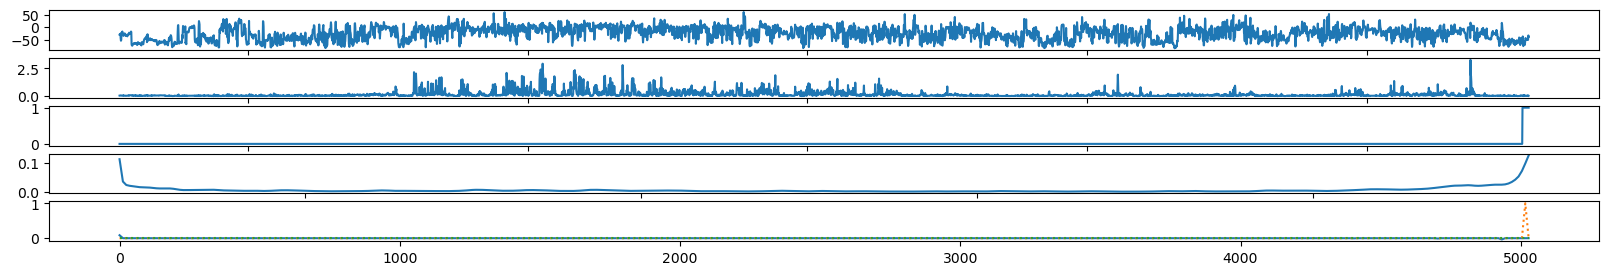

b7fc34995d0f
3


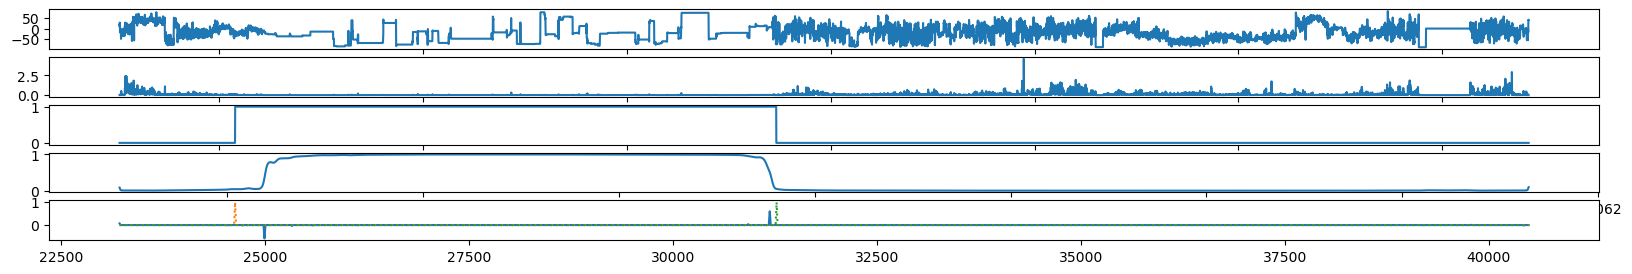

c535634d7dcd
8


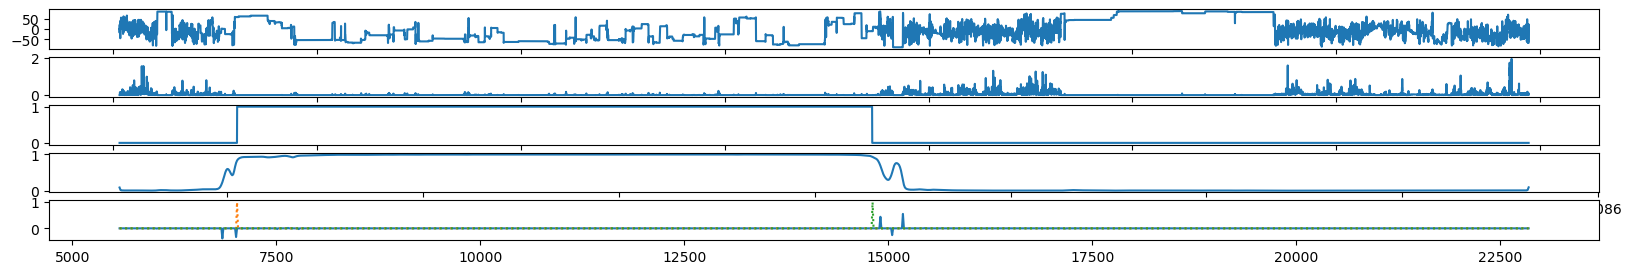

7476c0bd18d2
2


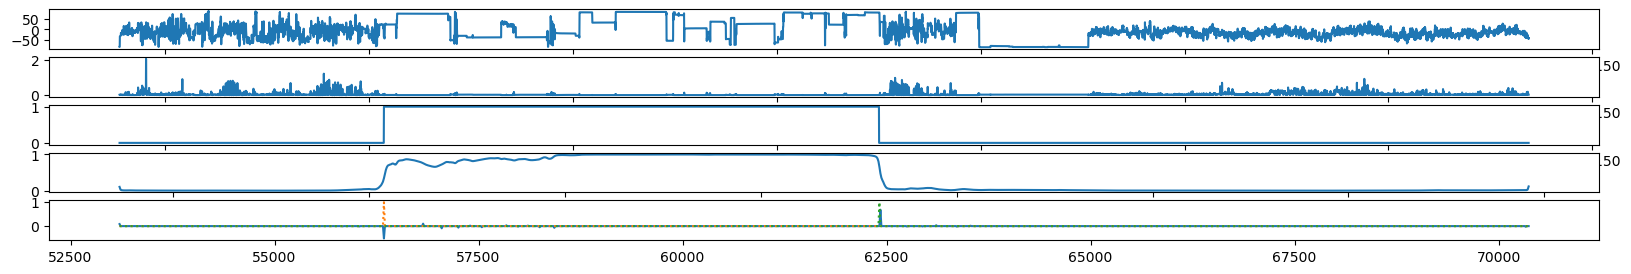

In [16]:
display_col = ["series_id", "series_date_key", "date","fold", "step"]
for idx, series_id in enumerate(mid_detect_series_id_list):
    if idx > 3:
        break
    print(series_id)
    input_df = orig_df[orig_df["series_id"] == series_id]
    pred_df = oof_df[oof_df["series_id"] == series_id]
    key_unique = input_df["series_date_key"].unique()
    print(len(key_unique))
    for key in key_unique:
        input_key_df = input_df[input_df["series_date_key"] == key]
        start_step = input_key_df["step"].min()
        end_step = input_key_df["step"].max()
        pred_key_df = pred_df[(pred_df["step"] >= start_step) & (pred_df["step"] <= end_step)]
        plt.figure(figsize=(20, 3))
        plt.subplot(5, 1, 1)
        plt.plot(input_key_df["anglez"])
        plt.subplot(5, 1, 2)
        plt.plot(input_key_df["enmo"])
        plt.subplot(5, 1, 3)
        plt.plot(input_key_df["event"])
        plt.subplot(5, 1, 4)
        plt.plot(pred_key_df["class_pred"])
        plt.subplot(5, 1, 5)
        plt.plot(pred_key_df["step"], pred_key_df["event_pred"])
        plt.plot(input_key_df[input_key_df["second"]==0]["step"], input_key_df[input_key_df["second"]==0]["event_onset"].values, ":")
        plt.plot(input_key_df[input_key_df["second"]==0]["step"], input_key_df[input_key_df["second"]==0]["event_wakeup"].values, ":")
        plt.show()
        break


In [17]:
series_id = "f56824b503a0"
def display_series_scoredf(orig_df, pred_df, oof_df, train_event_df, series_id):
    input_df = orig_df[orig_df["series_id"] == series_id]
    pred_df = oof_df[oof_df["series_id"] == series_id]
    key_unique = input_df["series_date_key"].unique()
    print(len(input_df)/17280)
    score_list = []
    key_list = []
    for key in key_unique:
        input_key_df = input_df[input_df["series_date_key"] == key]
        start_step = input_key_df["step"].min()
        end_step = input_key_df["step"].max()
        pred_key_df = pred_df[(pred_df["step"] >= start_step) & (pred_df["step"] <= end_step)]
        scoring_event_df = train_event_df[train_event_df["series_id"] == series_id].copy()
        scoring_event_df = scoring_event_df[(scoring_event_df["step"] >= start_step) & (scoring_event_df["step"] <= end_step)]
        sub_df = make_submission_df(pred_key_df, threshold=0.01)
        if len(sub_df["event"].unique()) < 2 or len(scoring_event_df["event"].unique()) < 2:
            score_list.append(0)
            key_list.append(key)
        else:
            score_list.append(score(scoring_event_df, sub_df))
            key_list.append(key)

    df = pd.DataFrame({"key": key_list, "score": score_list}).sort_values("score").reset_index(drop=True)
    display(pd.DataFrame({"key": key_list, "score": score_list}).sort_values("score", ascending=False).reset_index(drop=True))
    key_list = df["key"].values.tolist()
    return key_list


In [46]:
def show_input_target_in_key(orig_df, oof_df, key, series_id):
    input_df = orig_df[orig_df["series_id"] == series_id]
    pred_df = oof_df[oof_df["series_id"] == series_id]
    input_key_df = input_df[input_df["series_date_key"] == key]
    print(input_key_df["series_id"].unique())
    start_step = input_key_df["step"].min()
    end_step = input_key_df["step"].max()
    print("start step", start_step, "end step", end_step)
    pred_key_df = pred_df[(pred_df["step"] >= start_step) & (pred_df["step"] <= end_step)]
    scoring_event_df = train_event_df[train_event_df["series_id"] == series_id].copy()
    scoring_event_df = scoring_event_df[(scoring_event_df["step"] >= start_step) & (scoring_event_df["step"] <= end_step)]
    # datetimeの曜日を取得
    scoring_event_df["weekday"] = pd.to_datetime(scoring_event_df["timestamp"]).dt.weekday
    scoring_event_df["weekday_str"] = scoring_event_df["weekday"].replace({0: "Mon", 1: "Tue", 2: "Wed", 3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"})
    
    sleep_duration = (scoring_event_df["step"].max() - scoring_event_df["step"].min()) / 12 / 60
    print("sleep duration", sleep_duration)
    display(scoring_event_df)
    sub_df = make_submission_df(pred_key_df, threshold=0.01)
    print(scoring_event_df["step"].values)

    plt.figure(figsize=(20, 5))
    plt.subplot(5, 1, 1)
    plt.plot(input_key_df["anglez"])
    plt.subplot(5, 1, 2)
    plt.plot(input_key_df["enmo"])
    plt.subplot(5, 1, 3)
    plt.plot(input_key_df["step"], input_key_df["event"])
    # plt.plot(input_key_df["step"]-12*60*6, input_key_df["event"])
    plt.subplot(5, 1, 4)
    plt.plot(pred_key_df["class_pred"])
    plt.subplot(5, 1, 5)
    plt.plot(pred_key_df["step"], pred_key_df["event_pred"])
    plt.plot(input_key_df[input_key_df["second"]==0]["step"], input_key_df[input_key_df["second"]==0]["event_onset"].values, ":")
    plt.plot(input_key_df[input_key_df["second"]==0]["step"], input_key_df[input_key_df["second"]==0]["event_wakeup"].values, ":")
    plt.tight_layout()
    plt.show()


In [19]:
display_series_scoredf(orig_df, pred_df, oof_df, train_event_df, series_id="f56824b503a0")


12.0


,key,score
0,7411,0.425000
1,7400,0.350000
2,7401,0.316667
3,7412,0.316667
4,7402,0.233333
5,7404,0.183333
6,7408,0.166667
7,7410,0.150000
8,7413,0.050000
9,7409,0.020000


[7403, 7405, 7409, 7413, 7410, 7408, 7404, 7402, 7401, 7412, 7400, 7411]

['f56824b503a0']
start step 213300.0 end step 230579.0
sleep duration 8.3


,series_id,night,event,step,timestamp,weekday,weekday_str
9188,f56824b503a0,13,onset,215280.0,2018-10-13T22:45:00-0400,5,Sat
9189,f56824b503a0,13,wakeup,221256.0,2018-10-14T07:03:00-0400,6,Sun


[215280. 221256.]


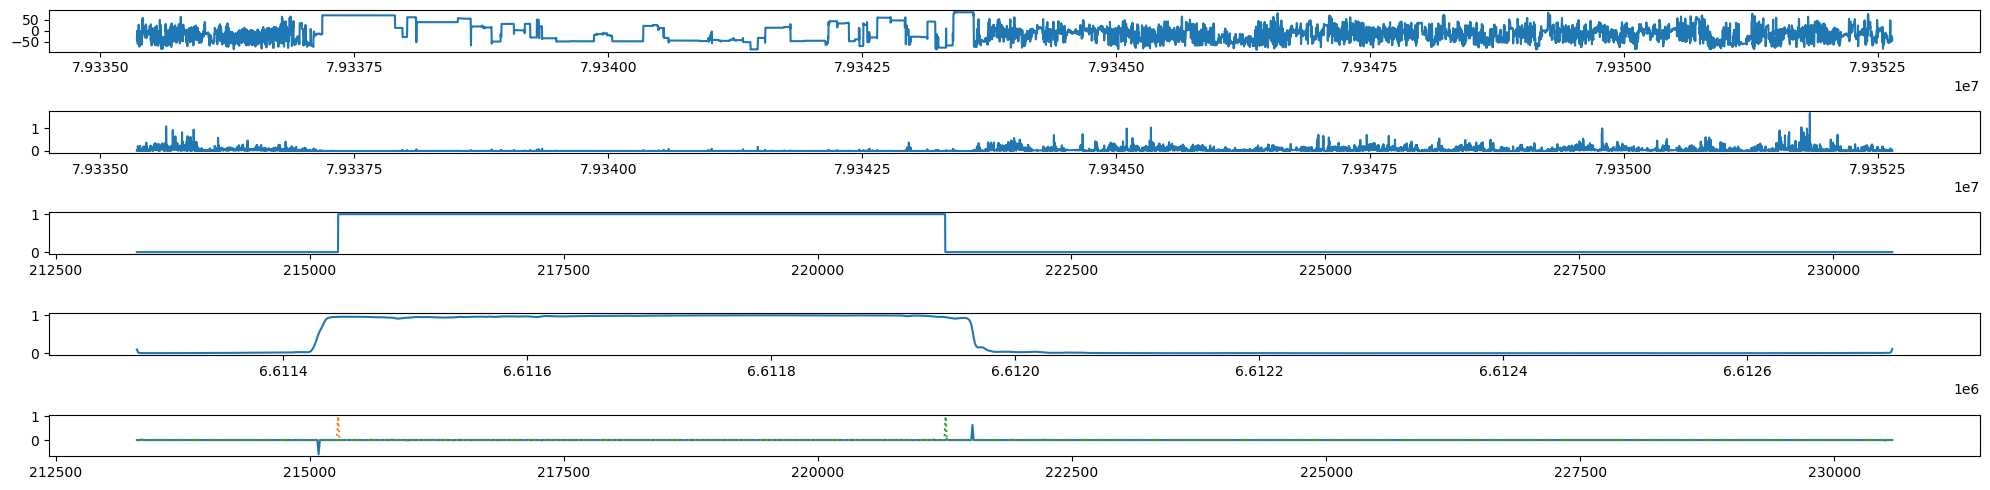

In [47]:
show_input_target_in_key(orig_df, oof_df, series_id="f56824b503a0", key=7411)


In [48]:
series_id = "f56824b503a0"
display_series_scoredf(orig_df, pred_df, oof_df, train_event_df, series_id=series_id)


12.0


,key,score
0,7411,0.425000
1,7400,0.350000
2,7401,0.316667
3,7412,0.316667
4,7402,0.233333
5,7404,0.183333
6,7408,0.166667
7,7410,0.150000
8,7413,0.050000
9,7409,0.020000


[7403, 7405, 7409, 7413, 7410, 7408, 7404, 7402, 7401, 7412, 7400, 7411]

['f56824b503a0']
start step 23220.0 end step 40499.0
sleep duration 8.083333333333334


,series_id,night,event,step,timestamp,weekday,weekday_str
9170,f56824b503a0,2,onset,24228.0,2018-10-02T21:24:00-0400,1,Tue
9171,f56824b503a0,2,wakeup,30048.0,2018-10-03T05:29:00-0400,2,Wed


[24228. 30048.]


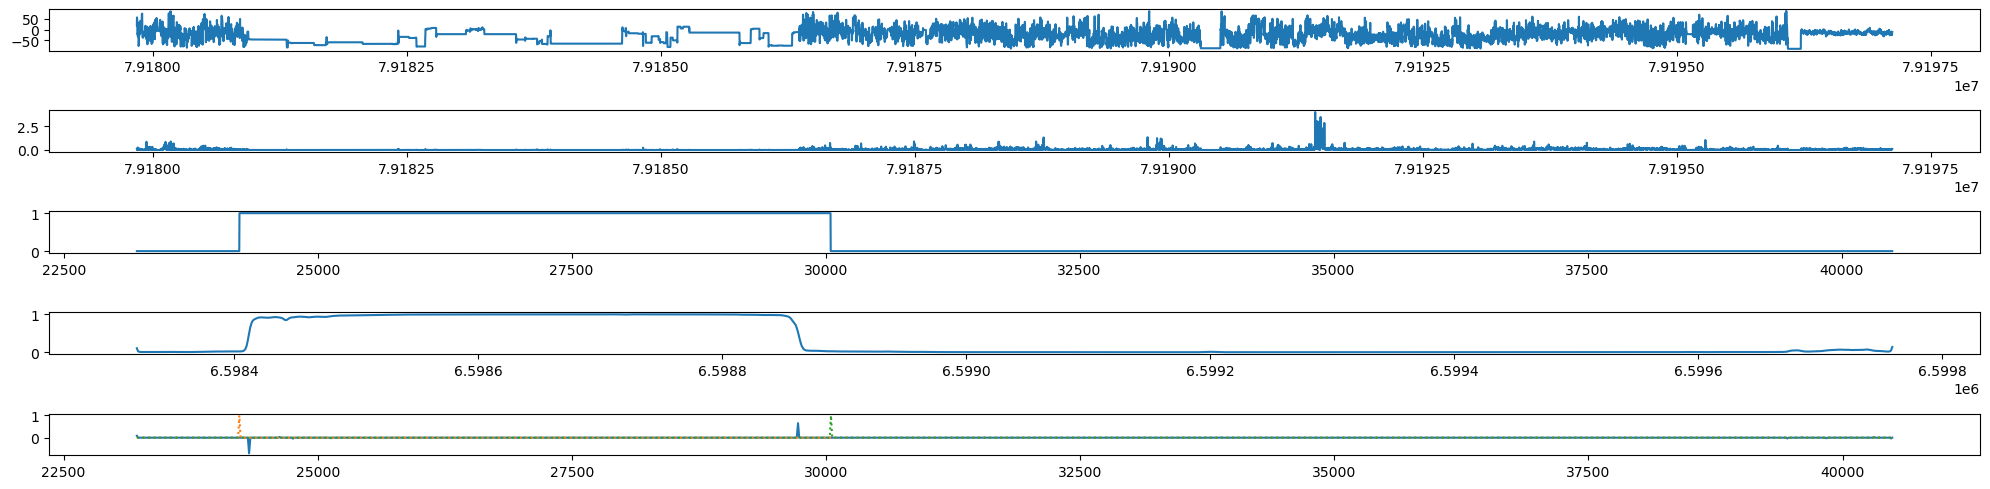

In [49]:
key=7400
show_input_target_in_key(orig_df, oof_df, series_id="f56824b503a0", key=key)


['f56824b503a0']
start step 75060.0 end step 92339.0
sleep duration 6.933333333333334


,series_id,night,event,step,timestamp,weekday,weekday_str
9176,f56824b503a0,5,onset,76584.0,2018-10-05T22:07:00-0400,4,Fri
9177,f56824b503a0,5,wakeup,81576.0,2018-10-06T05:03:00-0400,5,Sat


[76584. 81576.]


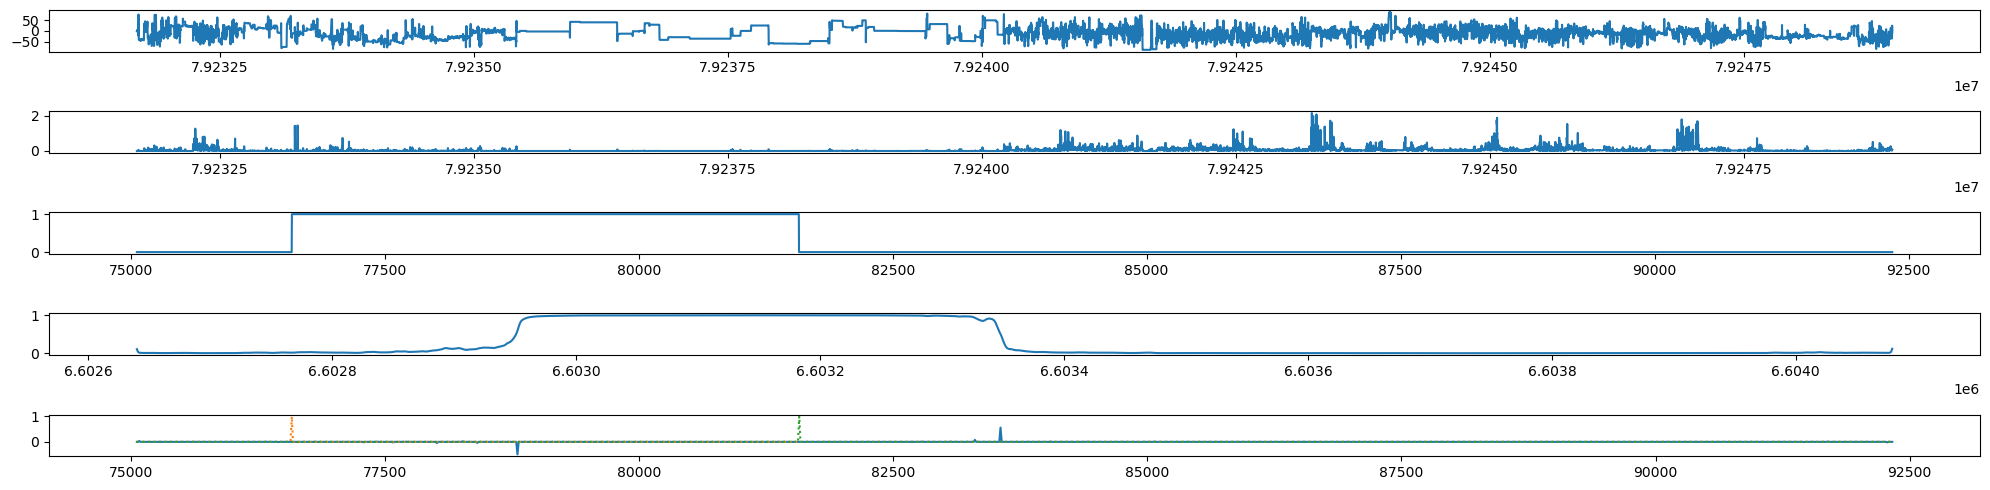

In [50]:
key=7403
show_input_target_in_key(orig_df, oof_df, series_id="f56824b503a0", key=key)


['f56824b503a0']
start step 109620.0 end step 126899.0
sleep duration 8.016666666666667


,series_id,night,event,step,timestamp,weekday,weekday_str
9180,f56824b503a0,7,onset,112656.0,2018-10-08T00:13:00-0400,0,Mon
9181,f56824b503a0,7,wakeup,118428.0,2018-10-08T08:14:00-0400,0,Mon


[112656. 118428.]


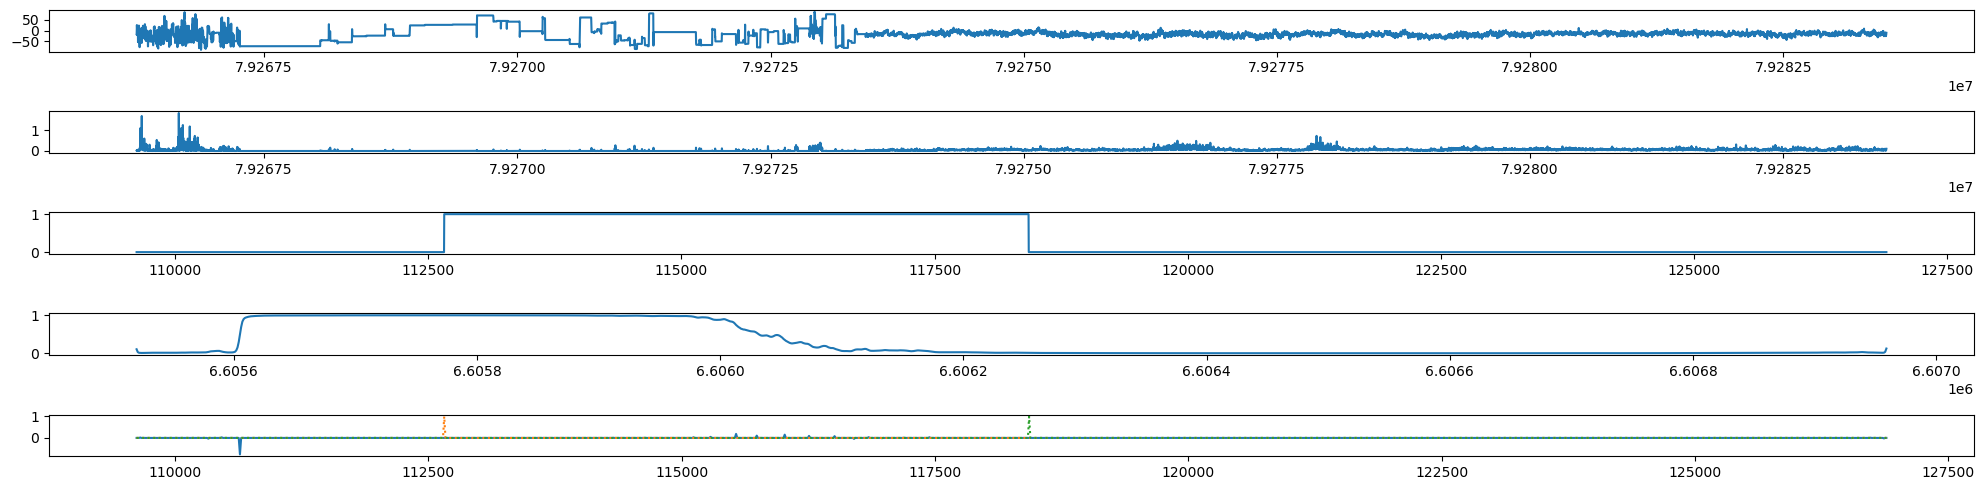

In [51]:
key=7405
show_input_target_in_key(orig_df, oof_df, series_id="f56824b503a0", key=key)


['f56824b503a0']
start step 161460.0 end step 178739.0
sleep duration 7.933333333333334


,series_id,night,event,step,timestamp,weekday,weekday_str
9182,f56824b503a0,10,onset,163032.0,2018-10-10T22:11:00-0400,2,Wed
9183,f56824b503a0,10,wakeup,168744.0,2018-10-11T06:07:00-0400,3,Thu


[163032. 168744.]


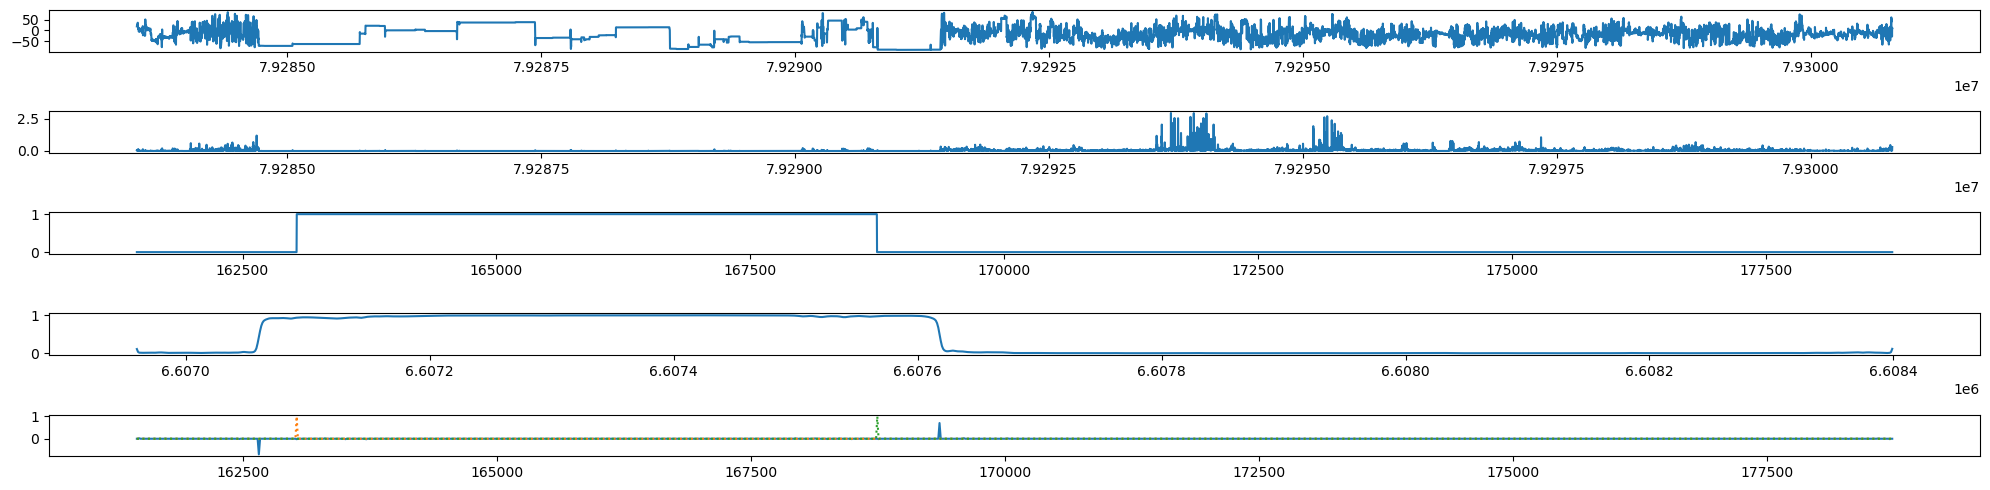

In [52]:
key=7408
show_input_target_in_key(orig_df, oof_df, series_id="f56824b503a0", key=key)


['f56824b503a0']
start step 178740.0 end step 196019.0
sleep duration 9.333333333333334


,series_id,night,event,step,timestamp,weekday,weekday_str
9184,f56824b503a0,11,onset,179928.0,2018-10-11T21:39:00-0400,3,Thu
9185,f56824b503a0,11,wakeup,186648.0,2018-10-12T06:59:00-0400,4,Fri


[179928. 186648.]


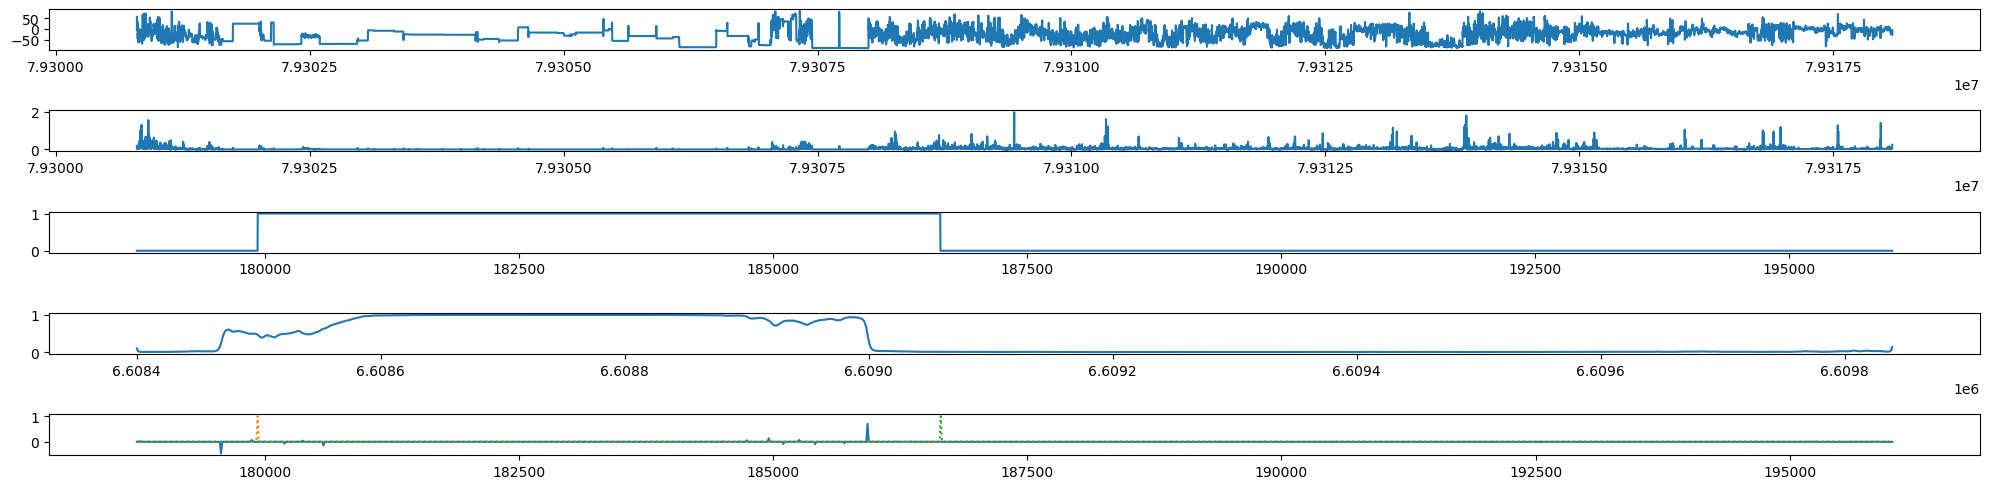

In [53]:
key=7409
show_input_target_in_key(orig_df, oof_df, series_id="f56824b503a0", key=key)


['f56824b503a0']
start step 213300.0 end step 230579.0
sleep duration 8.3


,series_id,night,event,step,timestamp,weekday,weekday_str
9188,f56824b503a0,13,onset,215280.0,2018-10-13T22:45:00-0400,5,Sat
9189,f56824b503a0,13,wakeup,221256.0,2018-10-14T07:03:00-0400,6,Sun


[215280. 221256.]


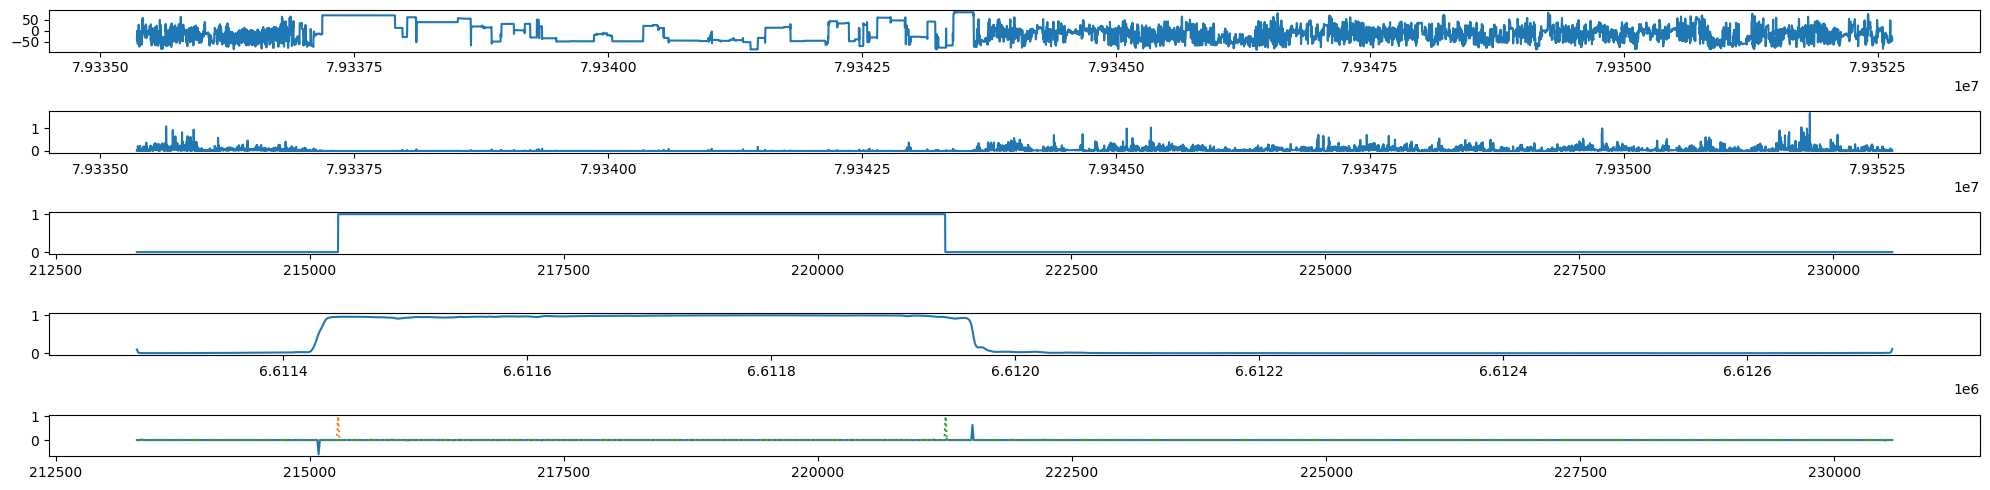

In [54]:
key=7411
show_input_target_in_key(orig_df, oof_df, series_id="f56824b503a0", key=key)


['f56824b503a0']
start step 230580.0 end step 247859.0
sleep duration 8.85


,series_id,night,event,step,timestamp,weekday,weekday_str
9190,f56824b503a0,14,onset,232440.0,2018-10-14T22:35:00-0400,6,Sun
9191,f56824b503a0,14,wakeup,238812.0,2018-10-15T07:26:00-0400,0,Mon


[232440. 238812.]


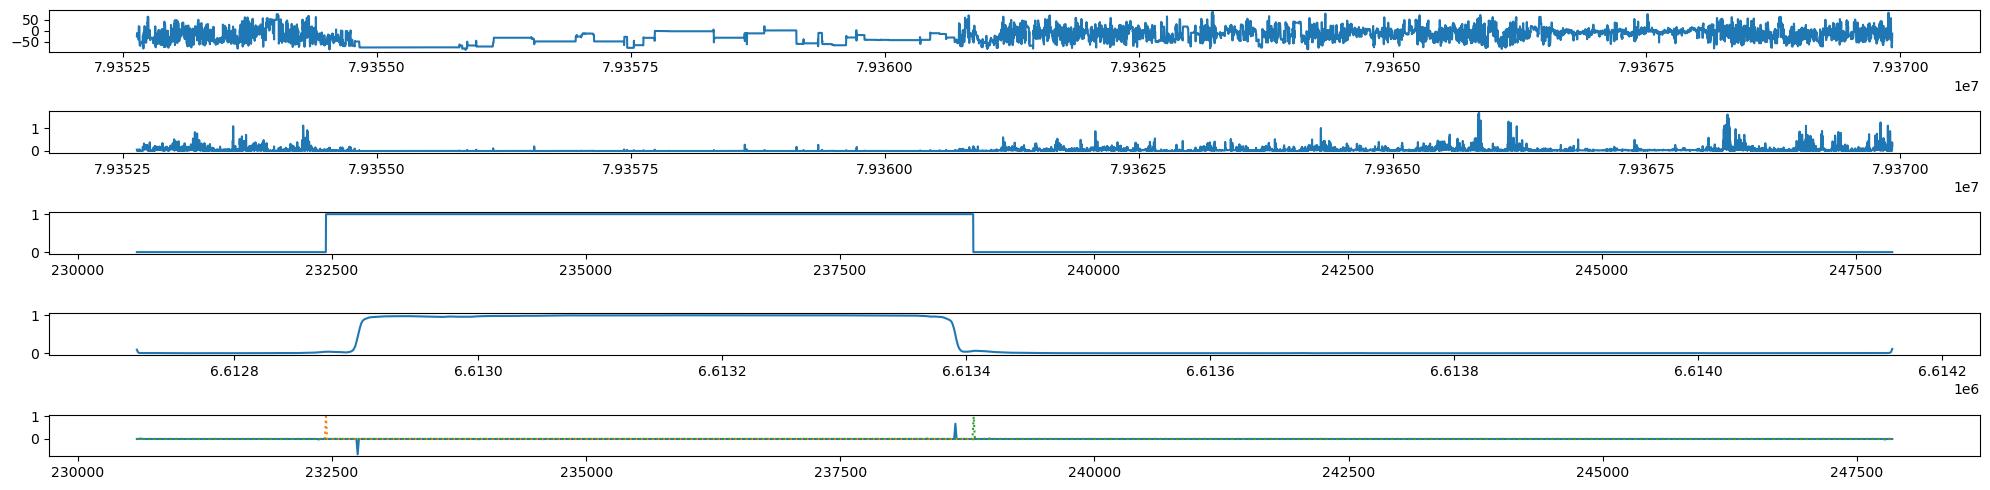

In [55]:
key=7412
show_input_target_in_key(orig_df, oof_df, series_id="f56824b503a0", key=key)


['f56824b503a0']
start step 247860.0 end step 265139.0
sleep duration 8.15


,series_id,night,event,step,timestamp,weekday,weekday_str
9192,f56824b503a0,15,onset,250032.0,2018-10-15T23:01:00-0400,0,Mon
9193,f56824b503a0,15,wakeup,255900.0,2018-10-16T07:10:00-0400,1,Tue


[250032. 255900.]


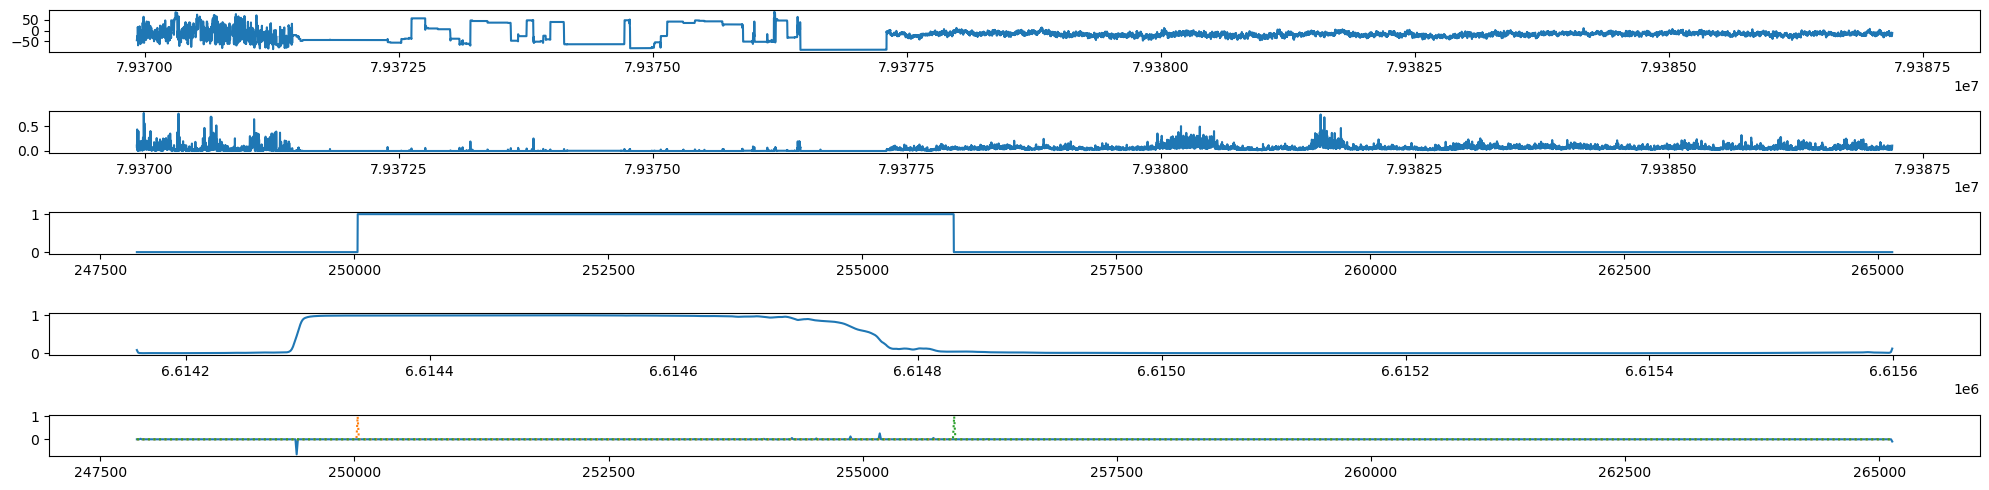

In [56]:
key=7413
show_input_target_in_key(orig_df, oof_df, series_id="f56824b503a0", key=key)


In [30]:
series_id = "4feda0596965"
key_list = display_series_scoredf(orig_df, pred_df, oof_df, train_event_df, series_id=series_id)


15.0


,key,score
0,2340,0.900000
1,2339,0.716667
2,2338,0.575000
3,2308,0.483333
4,2326,0.450000
5,2309,0.350000
6,2329,0.200000
7,2312,0.150000
8,2322,0.112500
9,2310,0.050000


['4feda0596965']
start step 90360.0 end step 107639.0


,series_id,night,event,step,timestamp
2961,4feda0596965,6,onset,92652.0,2018-05-17T23:11:00-0400
2962,4feda0596965,6,wakeup,98088.0,2018-05-18T06:44:00-0400


[92652. 98088.]


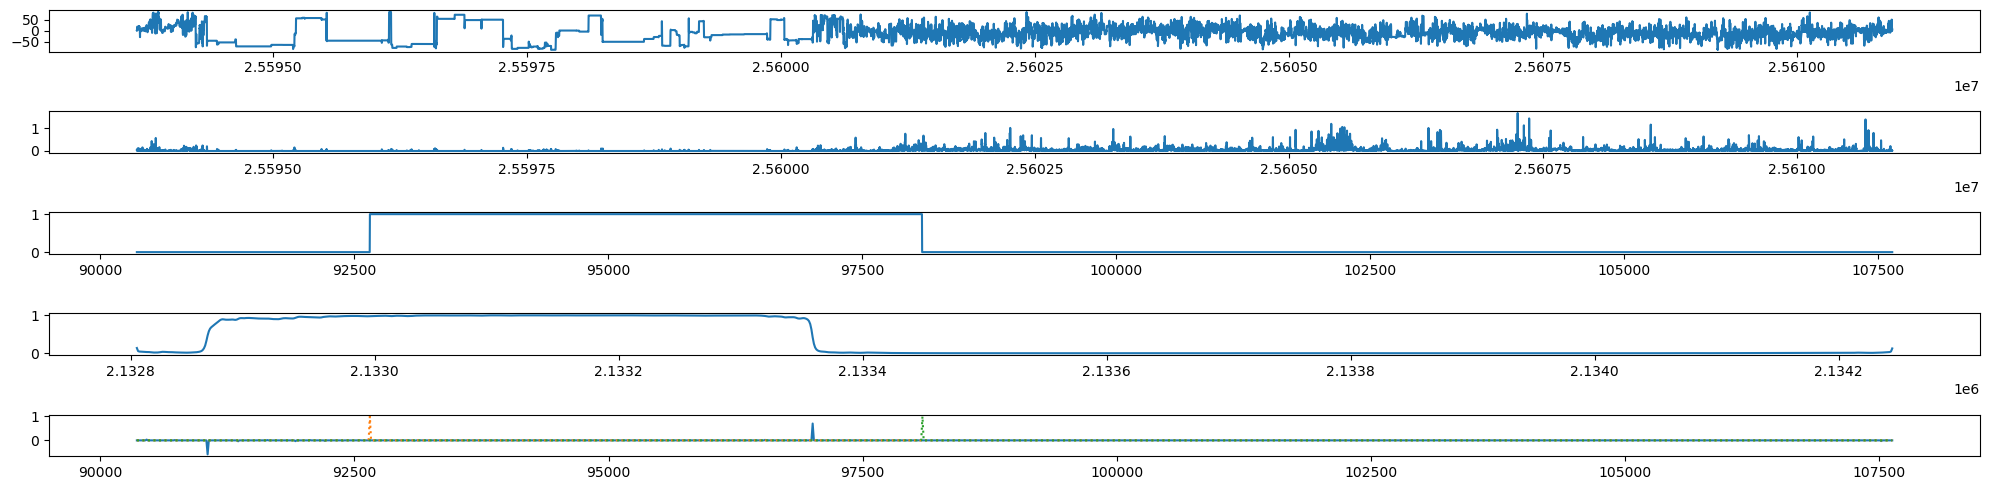

In [31]:
key = key_list[0]
show_input_target_in_key(orig_df, oof_df, series_id=series_id, key=key)


['4feda0596965']
start step 124920.0 end step 142199.0


,series_id,night,event,step,timestamp
2965,4feda0596965,8,onset,127812.0,2018-05-20T00:01:00-0400
2966,4feda0596965,8,wakeup,131352.0,2018-05-20T04:56:00-0400


[127812. 131352.]


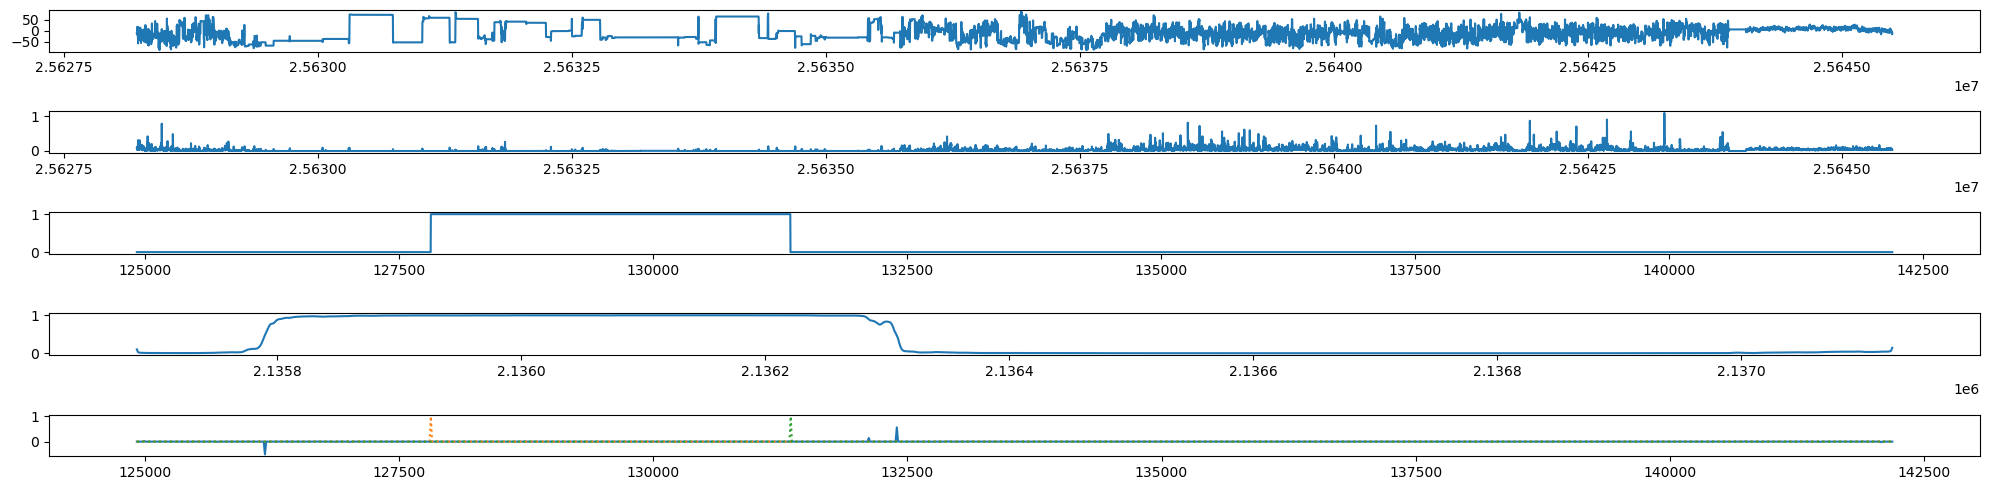

In [32]:
key = key_list[1]
show_input_target_in_key(orig_df, oof_df, series_id=series_id, key=key)


In [33]:
# bad_detect_series_id_list
series_id = "148471991ffb"
key_list = display_series_scoredf(orig_df, pred_df, oof_df, train_event_df, series_id=series_id)


16.0


,key,score
0,764,0.950000
1,770,0.950000
2,772,0.900000
3,748,0.850000
4,749,0.850000
5,769,0.750000
6,762,0.675000
7,773,0.675000
8,771,0.616667
9,768,0.580000


['148471991ffb']
start step 107820.0 end step 125099.0


,series_id,night,event,step,timestamp
873,148471991ffb,8,onset,124152.0,2019-01-17T17:41:00-0500


[124152.]


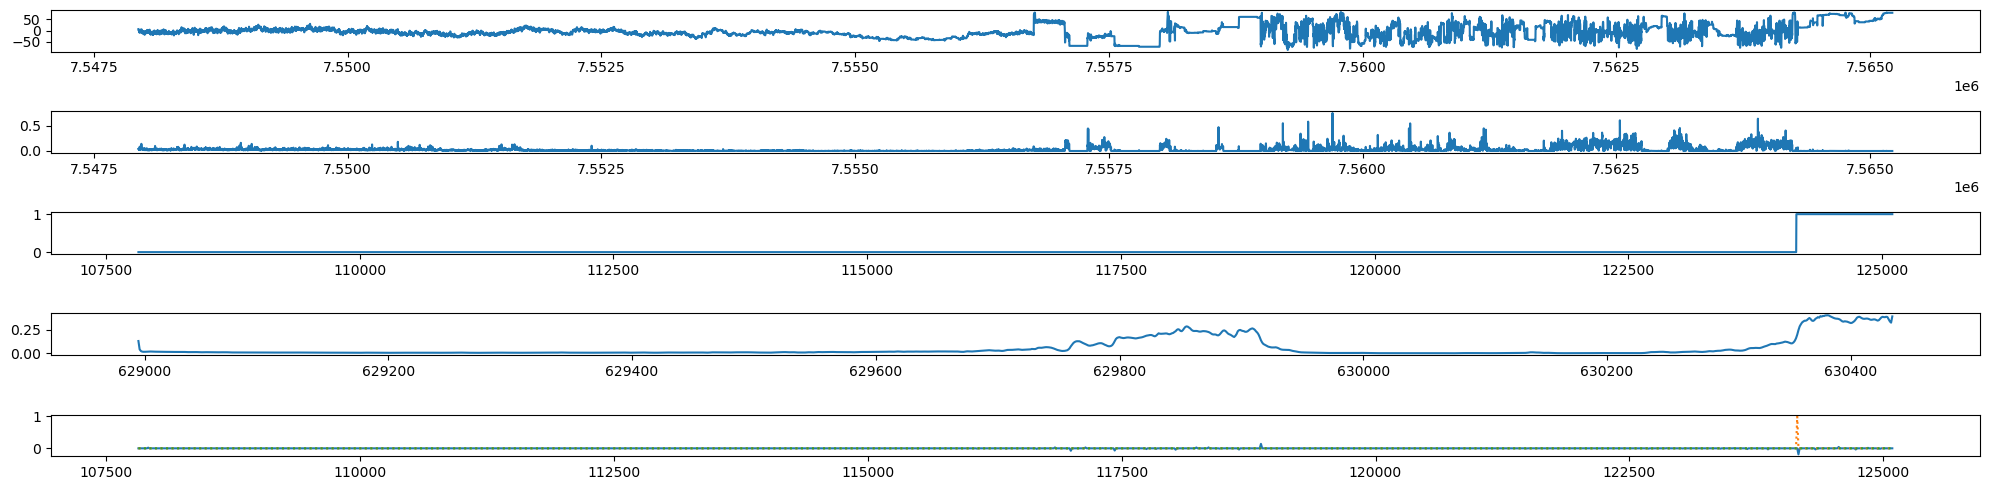

In [34]:
key = key_list[0]
show_input_target_in_key(orig_df, oof_df, series_id=series_id, key=key)


['148471991ffb']
start step 125100.0 end step 142379.0


,series_id,night,event,step,timestamp
874,148471991ffb,8,wakeup,133644.0,2019-01-18T06:52:00-0500


[133644.]


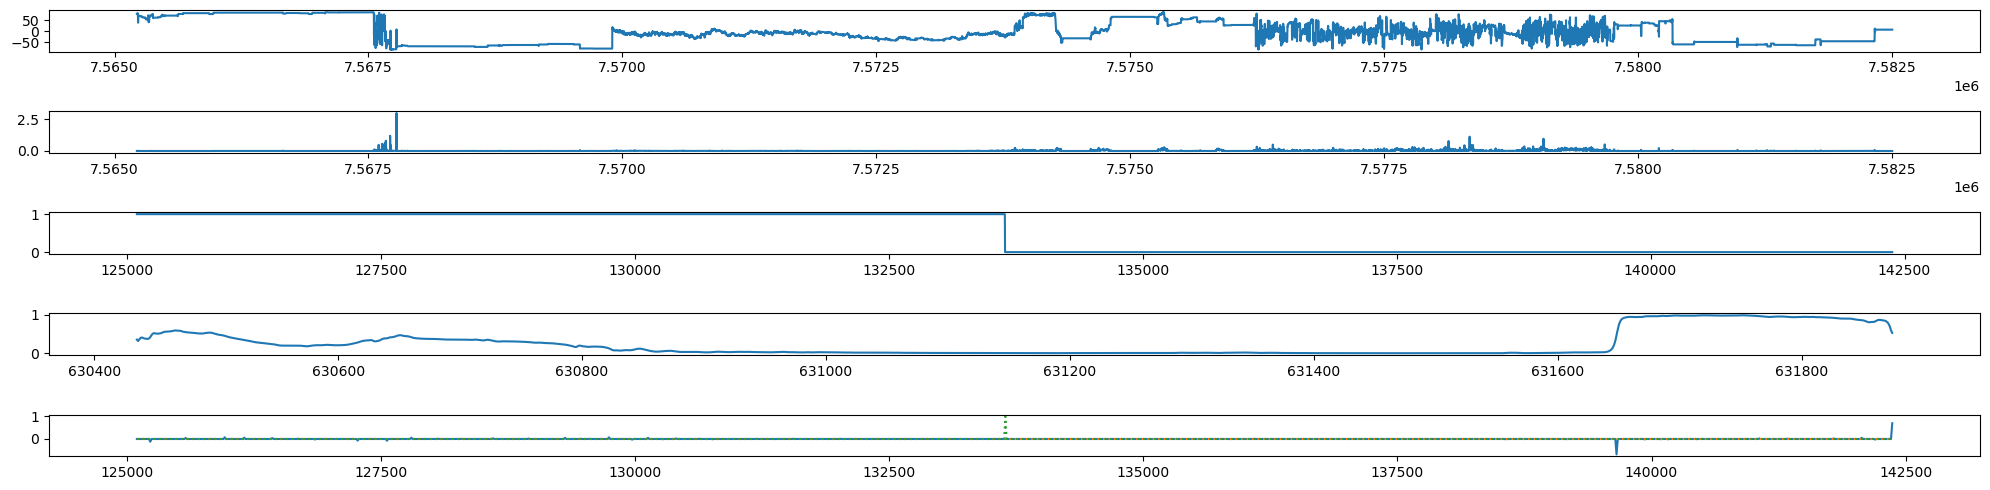

In [35]:
key = key_list[1]
show_input_target_in_key(orig_df, oof_df, series_id=series_id, key=key)


['148471991ffb']
start step 263340.0 end step 280619.0


,series_id,night,event,step,timestamp
877,148471991ffb,16,onset,267660.0,2019-01-26T01:00:00-0500
878,148471991ffb,16,wakeup,278808.0,2019-01-26T16:29:00-0500


[267660. 278808.]


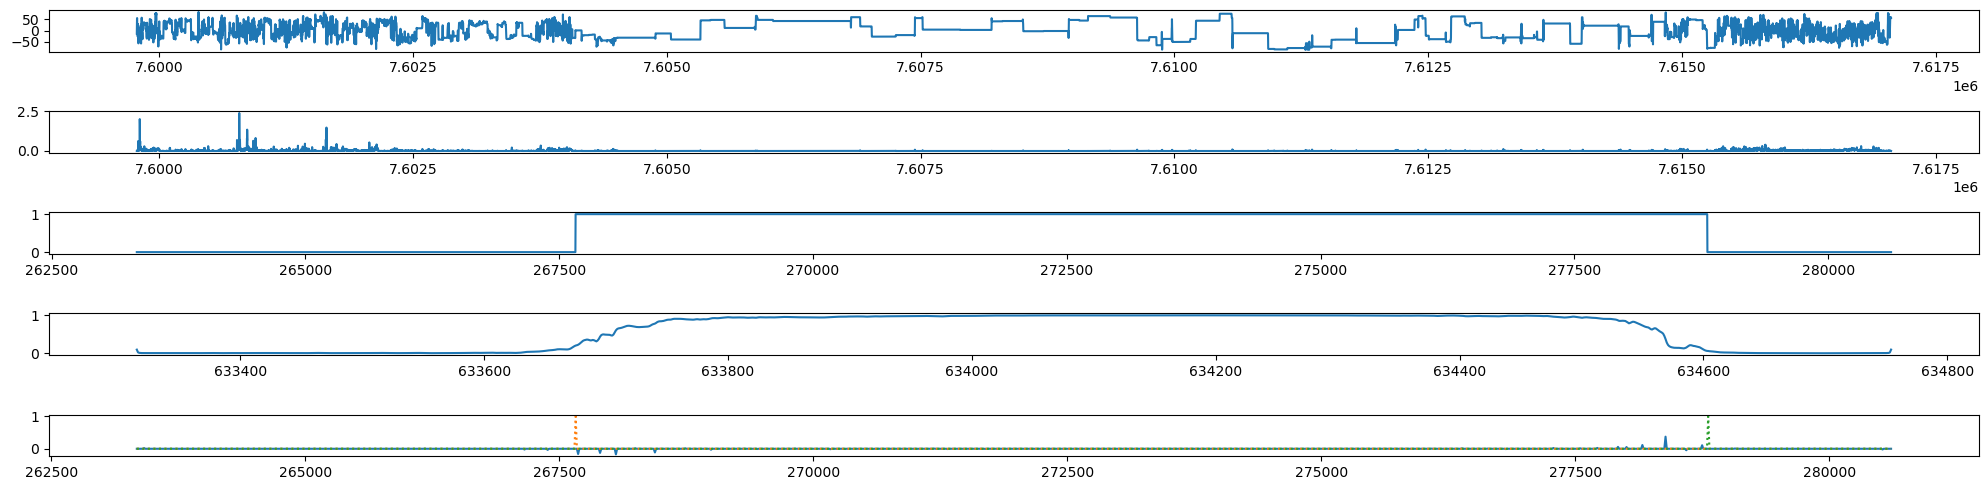

In [36]:
key = key_list[3]
show_input_target_in_key(orig_df, oof_df, series_id=series_id, key=key)


['148471991ffb']
start step 315180.0 end step 332459.0


,series_id,night,event,step,timestamp
883,148471991ffb,19,onset,321828.0,2019-01-29T04:14:00-0500
884,148471991ffb,19,wakeup,324840.0,2019-01-29T08:25:00-0500
885,148471991ffb,20,onset,332040.0,2019-01-29T18:25:00-0500


[321828. 324840. 332040.]


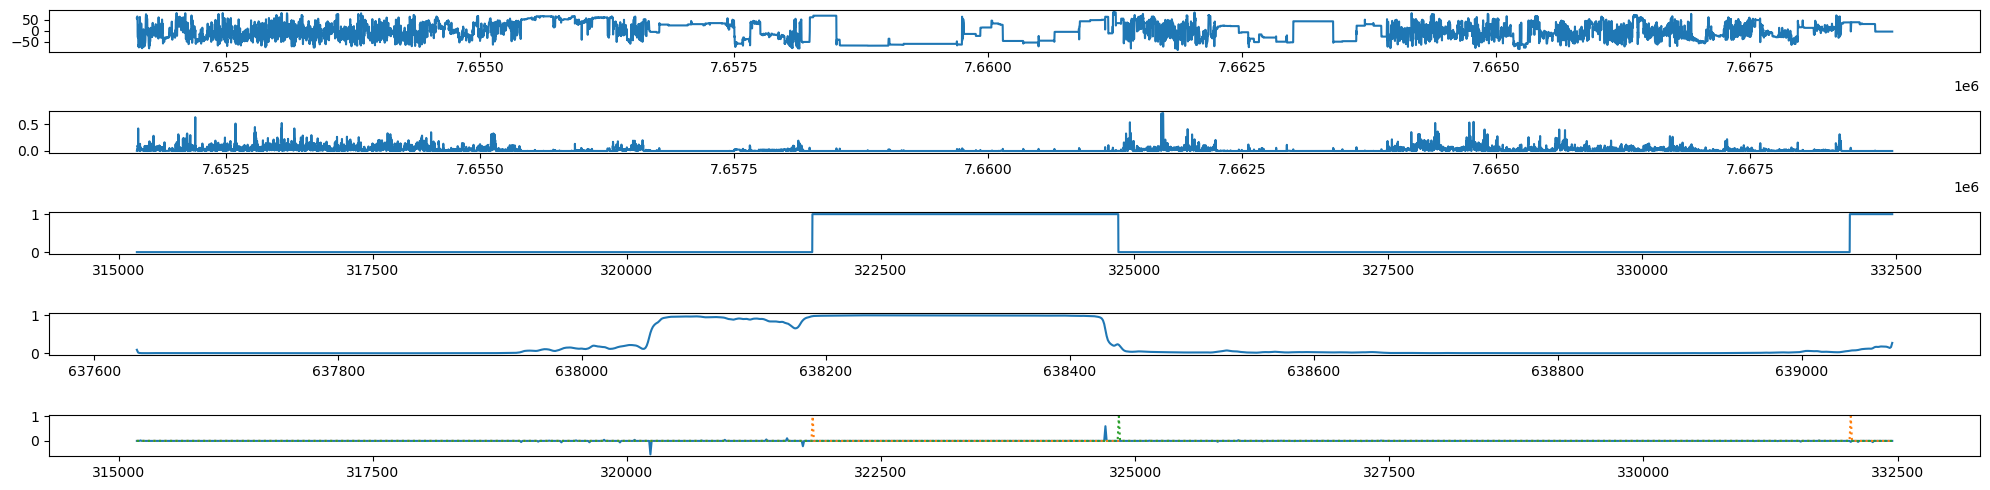

In [37]:
key = key_list[4]
show_input_target_in_key(orig_df, oof_df, series_id=series_id, key=key)


In [38]:
series_id = "60d31b0bec3b"
key_list = display_series_scoredf(orig_df, pred_df, oof_df, train_event_df, series_id=series_id)


12.0


,key,score
0,2841,0.366667
1,2838,0.325000
2,2836,0.238542
3,2827,0.185000
4,2840,0.154167
5,2832,0.120833
6,2831,0.094286
7,2830,0.076389
8,2828,0.075000
9,2833,0.062778


['60d31b0bec3b']
start step 144000.0 end step 161279.0


,series_id,night,event,step,timestamp
3705,60d31b0bec3b,9,onset,147816.0,2019-01-19T00:18:00-0500
3706,60d31b0bec3b,9,wakeup,152592.0,2019-01-19T06:56:00-0500


[147816. 152592.]


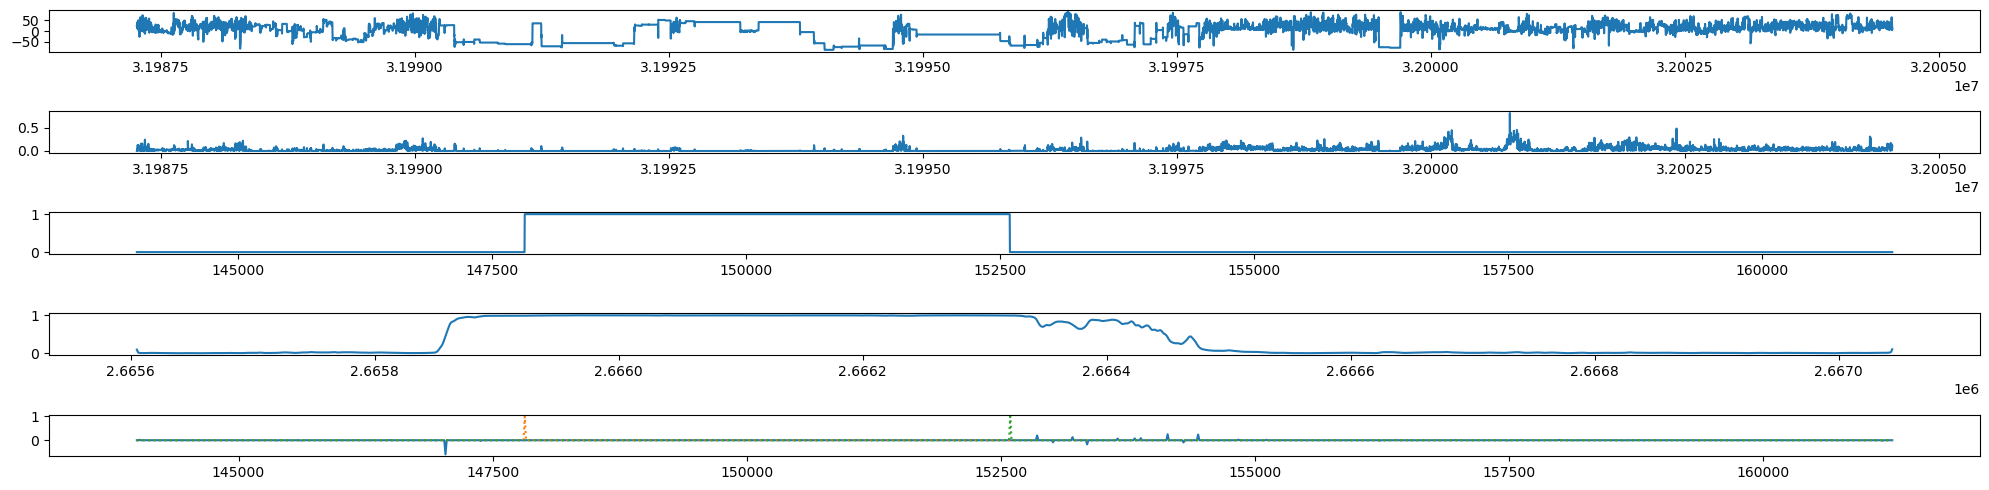

In [39]:
key = key_list[0]
show_input_target_in_key(orig_df, oof_df, series_id=series_id, key=key)


['60d31b0bec3b']
start step 161280.0 end step 178559.0


,series_id,night,event,step,timestamp
3707,60d31b0bec3b,10,onset,164292.0,2019-01-19T23:11:00-0500
3708,60d31b0bec3b,10,wakeup,170136.0,2019-01-20T07:18:00-0500


[164292. 170136.]


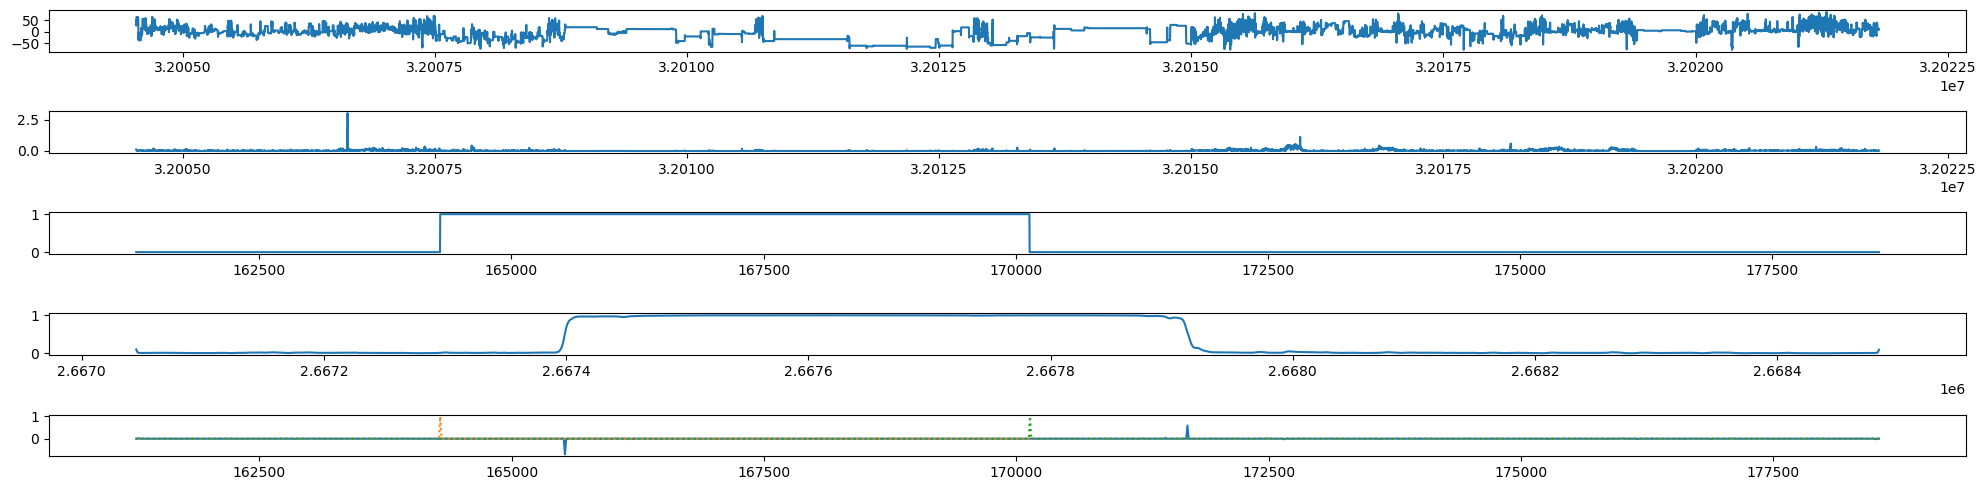

In [40]:
key = key_list[1]
show_input_target_in_key(orig_df, oof_df, series_id=series_id, key=key)


['60d31b0bec3b']
start step 74880.0 end step 92159.0


,series_id,night,event,step,timestamp
3697,60d31b0bec3b,5,onset,78816.0,2019-01-15T00:28:00-0500
3698,60d31b0bec3b,5,wakeup,83196.0,2019-01-15T06:33:00-0500


[78816. 83196.]


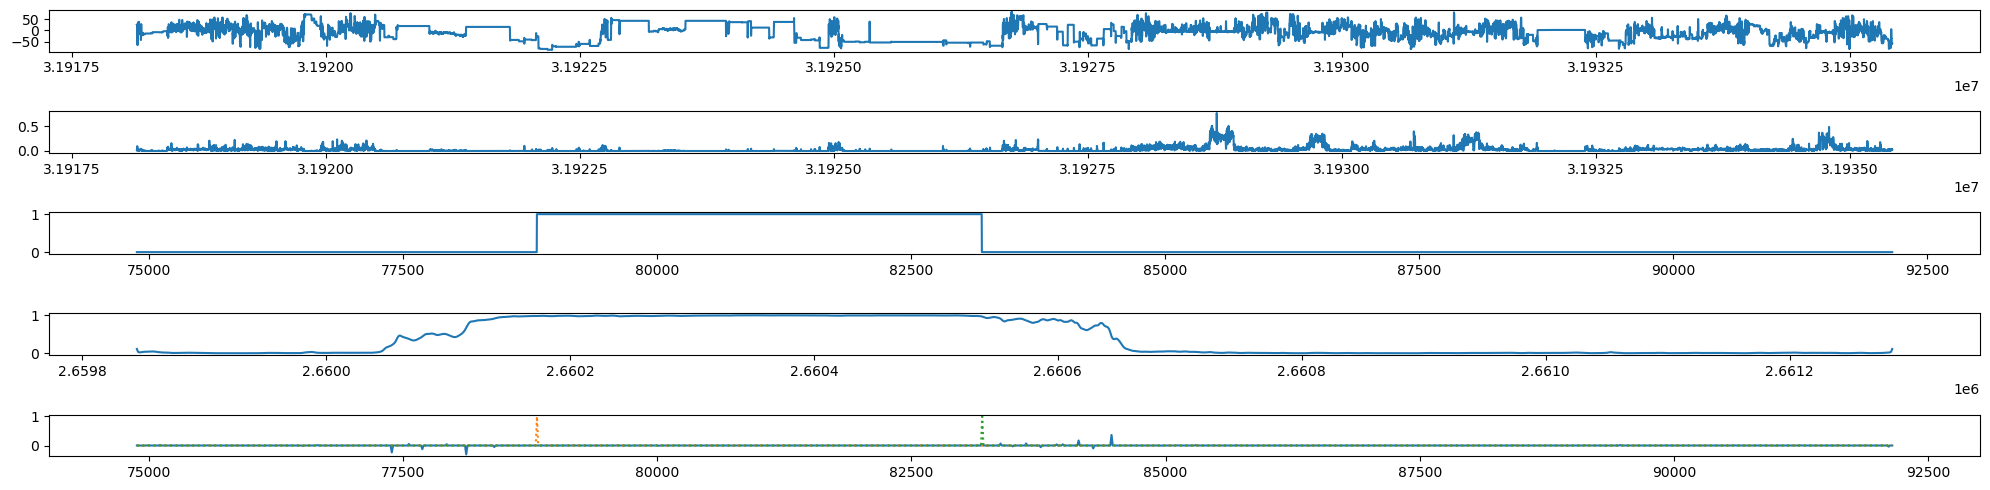

In [41]:
show_input_target_in_key(orig_df, oof_df, series_id=series_id, key=key_list[4])
